Epoch 1/50
72/72 - 2s - 29ms/step - loss: 0.0748 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 2/50
72/72 - 0s - 3ms/step - loss: 0.0121 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 3/50
72/72 - 0s - 3ms/step - loss: 0.0102 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/50
72/72 - 0s - 3ms/step - loss: 0.0091 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 5/50
72/72 - 0s - 3ms/step - loss: 0.0087 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 6/50
72/72 - 0s - 3ms/step - loss: 0.0084 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 7/50
72/72 - 0s - 3ms/step - loss: 0.0078 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 8/50
72/72 - 0s - 3ms/step - loss: 0.0077 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 9/50
72/72 - 0s - 3ms/step - loss: 0.0073 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 10/50
72/72 - 0s - 3ms/step - loss: 0.0071 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 11/50
72/72 - 0s - 3ms/step - loss: 0.0073 - val_loss: 0.0029 - learning_rate: 0.0

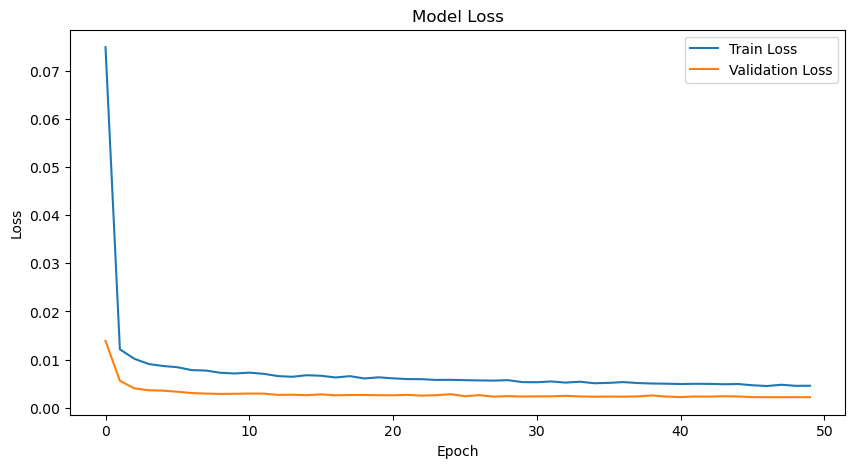

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test RMSE: 102791.26906882353
Test MAPE: 8.762018504323448
Test R-squared: 0.9298946560312482


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('C:/Users\calin\Downloads\Walmart_sales.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')  # Ensure Date is datetime type

# Extract additional time-related features
data['Day_of_Week'] = data['Date'].dt.dayofweek
data['Week_of_Year'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data['Quarter'] = data['Date'].dt.quarter
data['Year'] = data['Date'].dt.year

# Handling Outliers for 'Weekly_Sales'
cap = data['Weekly_Sales'].quantile(0.99)
data['Weekly_Sales'] = np.where(data['Weekly_Sales'] > cap, cap, data['Weekly_Sales'])

# Select features and normalize
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag', 'Day_of_Week', 'Week_of_Year', 'Month', 'Quarter', 'Year']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Function to create supervised learning dataset
def create_supervised_dataset(data, n_in=1, n_out=1):
    X, y = [], []
    for i in range(n_in, len(data) - n_out + 1):
        X.append(data[i - n_in:i, :])  # Past values as input
        y.append(data[i:i + n_out, 0])  # Future value(s) as output
    return np.array(X), np.array(y)

# Define the number of time steps (input sequences) and output steps (forecast horizon)
n_in = 3  # Increased window size to capture more past information
n_out = 1

# Create supervised dataset
X, y = create_supervised_dataset(scaled_data, n_in=n_in, n_out=n_out)

# Split data into train and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define LSTM model using the functional API
input_layer = Input(shape=(n_in, len(features)))
lstm_layer1 = LSTM(100, activation='relu', return_sequences=True)(input_layer)  # Increased units and added return_sequences
dropout1 = Dropout(0.2)(lstm_layer1)  # Dropout for regularization
lstm_layer2 = LSTM(50, activation='relu')(dropout1)  # Second LSTM layer
dropout2 = Dropout(0.2)(lstm_layer2)  # Additional dropout layer
output_layer = Dense(n_out)(dropout2)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='mse')

# Fit model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=72, verbose=2, validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)])

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Make predictions with the trained model
y_pred = model.predict(X_test)

# Invert scaling for predictions and actual values
y_pred_inv = scaler.inverse_transform(np.hstack((y_pred, X_test[:, 0, 1:])))[:, 0]
y_test_inv = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), X_test[:, 0, 1:])))[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE:', rmse)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('Test MAPE:', mape)

# Calculate R-squared
r_squared = r2_score(y_test_inv, y_pred_inv)
print('Test R-squared:', r_squared)

model.save('C:/Users\calin\Downloads\LSTM_NN.keras')